Timing test suite.

In the following cell: setting up
* imports
* reading data
* defining different functions that we want to time


In [2]:
import numpy as np
invm = np.linalg.inv
import xarray as xr
from blockinv_iterative import block_iter_inv_fbm, block_iter_inv_fdm, block_iter_inv_fdi
from blockinv_iterative_symmetric import block_inv_s, block_iter_inv_s, block_iter_inv_s2

invm1 = block_iter_inv_fdi
ds_1 = xr.open_dataset("data/regions_verify_isotope_202112_cov.nc")
bio_1 = ds_1["covariance_bio"]
anth_1 = ds_1["covariance_anth"]

ds_2 = xr.open_dataset("data/regions_verify_202104_cov.nc")
bio_2 = ds_2["covariance_bio"]
anth_2 = ds_2["covariance_anth"]

M = bio_2.to_numpy()


ds_sim = xr.open_dataset("simulated_data/simulation_04/s04_init.nc")
print(ds_sim)

<xarray.Dataset>
Dimensions:  (nstate: 5000, time: 100)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
Dimensions without coordinates: nstate
Data variables:
    state    (nstate) float64 ...
    cov      (nstate, nstate) float64 ...
    obs      (time) float64 ...
    R        (time, time) float64 ...
Attributes:
    comments:  nstate: 5000, nobs: 100, tw: 20, x_mu: 1, y_mu: 1800, x_std: 0...


In [1]:
1//3

0

Matrix inv accuracy test

In [2]:
k = int(len(M)/2)

inv1 = invm(M)
#inv2 = block_iter_inv_fdi(M, 5)
#inv3 = block_iter_inv_fdm(M, 5)
#inv4 = block_iter_inv_fbm(M, 5)
inv4 = block_iter_inv_s(M, 5)
inv5 = block_iter_inv_s2(M,5)

print(np.allclose(inv1, inv4), np.allclose(inv1, inv5))

True True


Plotting

-6.616444912082444e-16


/home/pietaril/Matrix_Inv/MI-AIM/shifted_colormap.py:45: UserWarning: Trying to register the cmap 'shifted' which already exists.
  plt.register_cmap(cmap=newcmap)


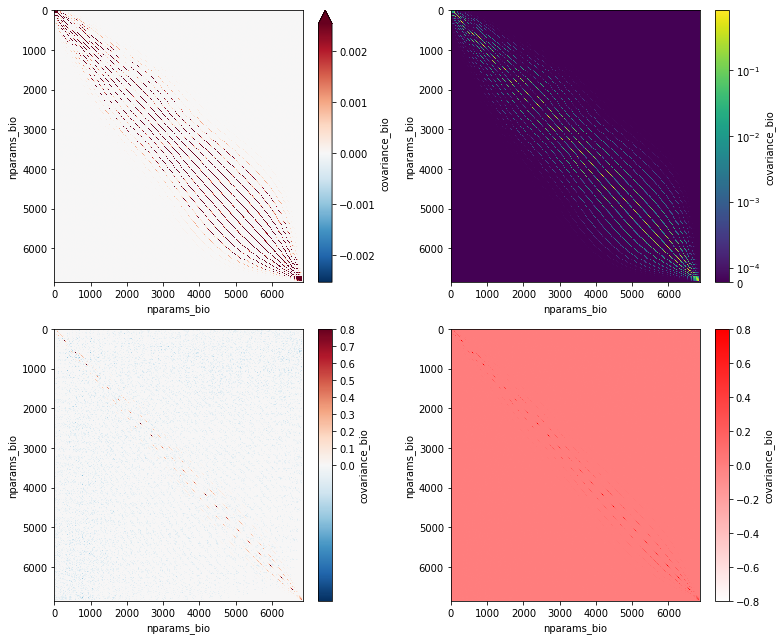

In [40]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from shifted_colormap import shiftedColorMap
# inv1 = xr.DataArray(inv1)


minval = bio_2.values.min()
print(minval)
maxval = bio_2.values.max()
midval = 0.2
# 1 - maxval / (maxval + abs(minval))


orig_cmap = matplotlib.cm.bwr
shifted_cmap = shiftedColorMap(cmap = orig_cmap, min_val = minval, max_val = maxval, name='shifted')

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2, figsize = (11,9))
bio_2.plot.imshow(ax = ax0, origin = 'upper', robust = True)
bio_2.plot.imshow(ax = ax1, origin = 'upper', cmap = 'viridis',
 norm = colors.SymLogNorm(vmin = minval, vmax = maxval, linthresh = 0.0001, linscale = 0.2))
bio_2.plot.imshow(ax = ax2, origin = 'upper', norm = colors.TwoSlopeNorm(vcenter = 0, vmin = minval, vmax = maxval))
bio_2.plot.imshow(ax = ax3, origin = 'upper', cmap = shifted_cmap)
plt.tight_layout()
plt.show()

# fig, ax = plt.subplots()
# bio_2.plot.imshow(origin = 'upper',
#  norm = colors.SymLogNorm(vmin = bio_2.values.min(), vmax = bio_2.values.max(), linthresh = 0.001, linscale=0.5))
# plt.tight_layout()
# plt.show()

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

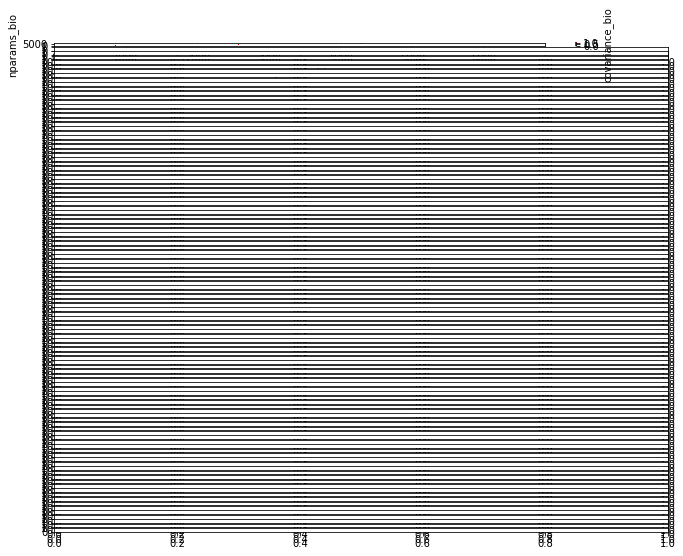

In [10]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

minval = np.quantile(bio_2.values, 10**(-7))
maxval = np.quantile(bio_2.values, 1-10**(-7))

class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

norm = MidpointNormalize(vmin=minval, vmax=maxval, midpoint=0)
cmap = 'bwr' 

#norm = colors.PowerNorm(0.15)
#cmap = 'viridis'
fig, ax = plt.subplots(111, figsize = (11,9))
bio_2.plot.imshow(ax = ax[0], cmap=cmap, norm=norm)
plt.colorbar()
plt.tight_layout
plt.show()

Timer

In [6]:


# time_d = %timeit -r 7 -n 25 -o invm(M)
# time_fdi = %timeit -r 7 -n 25 -o block_iter_inv_fdi(M,5)
# time_fdm = %timeit -r 7 -n 25 -o block_iter_inv_fdm(M,5)
# time_fbm = %timeit -r 7 -n 25 -o block_iter_inv_fbm(M,5)

%timeit block_iter_inv_s2(M,5)
%timeit block_iter_inv_s(M,5)




4.41 s ± 231 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8.8 s ± 2.19 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Timer results 

As far as I've understood, the timer runs -r <R> number of times and loops within each run -n <N> times, picking the minimum of those N loops.
So, to get accurate results, N should be rather large! 

BUT: FOR SOME REASON INCREASING NUMBER OF LOOPS ALSO SEEMS TO MAKE THE TIME LONGER, WHY? (e.g. s2: 7 runs 1 loop: 4.41 s ± 231 ms)

with M = bio_2.to_numpy(): 

np.linalg.inv:
* 8.57 s ± 358 ms per loop (mean ± std. dev. of 7 runs, 25 loops each)

block_iter_inv(M,5) [with for-loop, ind assigns, calls np.linalg.inv]
* 7.42 s ± 141 ms per loop (mean ± std. dev. of 7 runs, 25 loops each)

block_iter_inv(M,5) [with for-loop, multiple assign, calls np.linalg.inv] 
* 7.65 s ± 306 ms per loop (mean ± std. dev. of 7 runs, 25 loops each)

block_iter_inv(M,5) [with for-loop, multiple assign, calls block_inv]
* 7.86 s ± 391 ms per loop (mean ± std. dev. of 7 runs, 25 loops each)

block_iter_inv_s(M,5) [symmetric, uses transpose, with for & ind & def]
* 10.9 s ± 744 ms per loop (mean ± std. dev. of 7 runs, 25 loops each)

block_iter_invs2(M,5) [symmetric, no transpose, with for & ind & def]
* 7.87 s ± 565 ms per loop (mean ± std. dev. of 7 runs, 25 loops each)




Older results with 10 runs, 10 loops:

default invm: 8.54 s ± 1.48 s per loop (mean ± std. dev. of 10 runs, 10 loops each)

block_iter_inv(M,5):
    * with for-loop and block_inv: 6.79 s ± 432 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)
    * with for-loop and default inv: 7.52 s ± 1.31 s per loop (mean ± std. dev. of 10 runs, 10 loops each)


block_iter_inv_w(M,5), version using while-loop and block_inv: 7.1 s ± 392 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)

In [2]:
%load_ext scalene
%scrun block_iter_inv_fdm(M)


Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


In [2]:
%load_ext scalene
%scrun block_iter_inv_fdi(M)

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.
